In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.compose import ColumnTransformer

warnings.filterwarnings('ignore')

#### Reading in the merged data

In [2]:
df = pd.read_csv('./data/merged_dataset.csv')

In [3]:
df.head()

,county,county_fips_code,cases,deaths,stname,ctyname,tot_pop,deaths_per_hun_thou,cnty_name,unemployment_rate,...,SVI__B,SVI__C,SVI__D,tot_male,tot_female,tot_wa_pop,tot_ba_pop,tot_aa_pop,tot_na_pop,minority_group_total
0,Autauga,1001,12738,163.0,Alabama,Autauga County,55869.0,291.753924,"Autauga County, AL",4.9,...,1.0,0.0,0.0,27092,28777,42607,11237,656,58,11237
1,Baldwin,1003,47143,605.0,Alabama,Baldwin County,223234.0,271.016064,"Baldwin County, AL",5.6,...,0.0,0.0,0.0,108247,114987,195198,19593,2380,154,19593
2,Barbour,1005,4741,83.0,Alabama,Barbour County,24686.0,336.222960,"Barbour County, AL",7.0,...,0.0,0.0,1.0,13064,11622,12134,11906,116,52,11906
3,Bibb,1007,5385,95.0,Alabama,Bibb County,22394.0,424.220773,"Bibb County, AL",6.6,...,0.0,1.0,0.0,11929,10465,17191,4763,48,26,4763
4,Blount,1009,12648,203.0,Alabama,Blount County,57826.0,351.053159,"Blount County, AL",4.1,...,1.0,0.0,0.0,28472,29354,55412,978,185,67,978


#### Determining numerical features

In [4]:
numerical_features = df.select_dtypes(include= 'number').columns.tolist()
print(f'There are {len(numerical_features)} numerical features:','\n')
print(numerical_features)

There are 49 numerical features: 

['county_fips_code', 'cases', 'deaths', 'tot_pop', 'deaths_per_hun_thou', 'unemployment_rate', 'med_cases_per_100k_change', 'med_per_test_results_positive', 'transmission_level_high', 'transmission_level_low', 'transmission_level_moderate', 'transmission_level_substantial', 'InBedsOccAnyPat__Numbeds_Est', 'InBedsOccCOVID__Numbeds_Est', 'ICUBedsOccAnyPat__N_ICUBeds_Est', 'cases_per_10k', 'high_transmission', 'mask_never', 'mask_rarely', 'mask_sometimes', 'mask_frequently', 'mask_always', 'good_masking_practices', 'biden_votes', 'trump_votes', 'total_votes', 'land_area_sqmi', 'population_density', 'total_beds_7_day_sum', 'inpatient_beds_used_7_day_sum', 'inpatient_beds_used_covid_7_day_sum', 'inpatient_beds_7_day_sum', 'total_icu_beds_7_day_sum', 'total_staffed_adult_icu_beds_7_day_sum', 'icu_beds_used_7_day_sum', 'staffed_icu_adult_patients_confirmed_covid_7_day_sum', 'total_adult_patients_hospitalized_confirmed_covid_7_day_sum', 'county_vac_pct', 'SVI

#### Check for nulls

In [5]:
df[numerical_features].isnull().sum()

county_fips_code                                                 0
cases                                                            0
deaths                                                           0
tot_pop                                                          0
deaths_per_hun_thou                                              0
unemployment_rate                                                1
med_cases_per_100k_change                                        0
med_per_test_results_positive                                   18
transmission_level_high                                          0
transmission_level_low                                           0
transmission_level_moderate                                      0
transmission_level_substantial                                   0
InBedsOccAnyPat__Numbeds_Est                                     1
InBedsOccCOVID__Numbeds_Est                                      1
ICUBedsOccAnyPat__N_ICUBeds_Est                               

#### Changing target variable to binary 

In [6]:
df.deaths_per_hun_thou = df.deaths_per_hun_thou.map(lambda x : 0 if x < np.percentile(df.deaths_per_hun_thou, 75) else 1)
df.deaths_per_hun_thou.value_counts()

0    2349
1     784
Name: deaths_per_hun_thou, dtype: int64

#### Baseline score

In [7]:
1 - df.deaths_per_hun_thou.mean()

0.7497606128311523

### Transformations

#### Possible features that correlate too much with each other (PCA should have taken care of them)
*'mask_never', 'mask_rarely', 'mask_sometimes', 'mask_frequently', 'mask_always','cases_per_10k', 'high_transmission', 'total_beds_7_day_sum'*

- `deaths_per_hun_thou` is the target variable
- `deaths` is too correlated to the target variable
- `county_fips_code` is just an ID number

In [8]:
# dropping numerical features that are redudant or unecessary

numerical_features_t = df.drop(['deaths_per_hun_thou','deaths','county_fips_code'],axis = 1).select_dtypes(include= 'number').columns.tolist()
print(f'There are NOW {len(numerical_features_t)} numerical features:','\n')
print(numerical_features_t)

There are NOW 46 numerical features: 

['cases', 'tot_pop', 'unemployment_rate', 'med_cases_per_100k_change', 'med_per_test_results_positive', 'transmission_level_high', 'transmission_level_low', 'transmission_level_moderate', 'transmission_level_substantial', 'InBedsOccAnyPat__Numbeds_Est', 'InBedsOccCOVID__Numbeds_Est', 'ICUBedsOccAnyPat__N_ICUBeds_Est', 'cases_per_10k', 'high_transmission', 'mask_never', 'mask_rarely', 'mask_sometimes', 'mask_frequently', 'mask_always', 'good_masking_practices', 'biden_votes', 'trump_votes', 'total_votes', 'land_area_sqmi', 'population_density', 'total_beds_7_day_sum', 'inpatient_beds_used_7_day_sum', 'inpatient_beds_used_covid_7_day_sum', 'inpatient_beds_7_day_sum', 'total_icu_beds_7_day_sum', 'total_staffed_adult_icu_beds_7_day_sum', 'icu_beds_used_7_day_sum', 'staffed_icu_adult_patients_confirmed_covid_7_day_sum', 'total_adult_patients_hospitalized_confirmed_covid_7_day_sum', 'county_vac_pct', 'SVI__A', 'SVI__B', 'SVI__C', 'SVI__D', 'tot_male', '

In [9]:
# pipe imputes missing data and scales it
numeric_pipeline = Pipeline(steps=[
    ('impute', IterativeImputer(random_state=73,
                               initial_strategy='median')),
    ('scale', StandardScaler())
])


In [10]:
# fits the pipe to the raw data
full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features_t)
])

#### Modeling 

In [11]:
X = df[numerical_features_t]
y = df.deaths_per_hun_thou

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.3, random_state=42)

In [12]:
# fit all variables to logreg pipeline
log_reg = LogisticRegression(max_iter=10000, tol=0.1)

log_reg_pipe = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', log_reg)
])

In [13]:
_ = log_reg_pipe.fit(X_train, y_train)

# log_reg_pipe.score(X_valid, y_valid)

### PCA

In [14]:
pca = PCA()
log_reg = LogisticRegression()

log_reg_pipe = Pipeline(steps=[
    ('preprocess', full_processor),
    ('pca',pca),
    ('model', log_reg)
])

In [15]:
# perform GridSearch on logreg pipeline /w PCA
param_grid = {
    "pca__n_components": [5, 15, 20, 25, 30],
    "model__C": np.logspace(-4, 4, 4),
    "model__penalty": ['l1','l2']
}
search = GridSearchCV(log_reg_pipe, param_grid, n_jobs=2)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.767):
{'model__C': 21.54434690031882, 'model__penalty': 'l2', 'pca__n_components': 25}


#### Determining principle components

In [16]:
pca.fit(full_processor.fit_transform(X_train))

PCA()

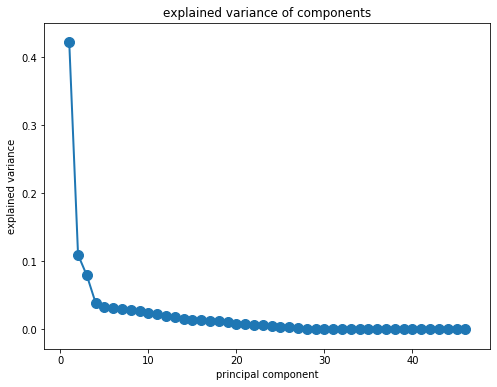

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1,47), pca.explained_variance_ratio_, lw=2)
ax.scatter(range(1,47), pca.explained_variance_ratio_, s=100)
ax.set_title('explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance');

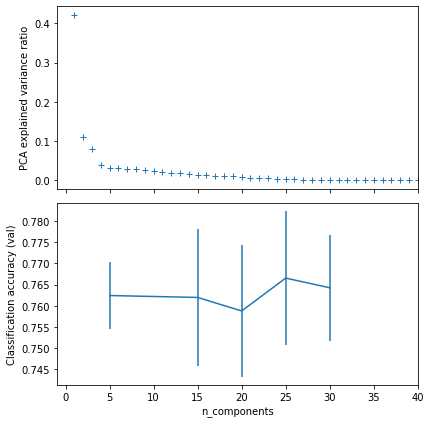

In [18]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")


# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = "param_pca__n_components"
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, "mean_test_score")
)

best_clfs.plot(
    x=components_col, y="mean_test_score", yerr="std_test_score", legend=False, ax=ax1
)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")

plt.xlim(-1, 40)

plt.tight_layout()
plt.show()

In [19]:
# 5 components make up ~70% of the variance ratio
sum(pca.explained_variance_ratio_[:5])

0.6812125738544194

In [20]:
# map the pc's to a dataframe 
pca_df = pd.DataFrame(pca.transform(full_processor.fit_transform(X)),
                      columns=['pr_comp_' + str(i) for i in range(full_processor.fit_transform(X).shape[1])])
pca_df.head()

,pr_comp_0,pr_comp_1,pr_comp_2,pr_comp_3,pr_comp_4,pr_comp_5,pr_comp_6,pr_comp_7,pr_comp_8,pr_comp_9,...,pr_comp_36,pr_comp_37,pr_comp_38,pr_comp_39,pr_comp_40,pr_comp_41,pr_comp_42,pr_comp_43,pr_comp_44,pr_comp_45
0,-0.585097,-0.783503,-3.154178,0.914542,-0.612056,0.560723,-2.078037,1.390703,-0.188246,1.430113,...,0.009004,0.001283,-0.003296,-0.001770,-0.000905,-0.000943,-0.002698,0.001963,-0.000634,0.000447
1,1.171203,-0.913908,-0.266487,0.226877,-1.484660,0.016580,0.732758,-0.046347,1.649595,2.735149,...,-0.016122,-0.006220,-0.019453,0.008012,-0.012408,0.003493,0.002840,0.001834,-0.002124,-0.000104
2,-0.853082,-1.367427,-2.469864,1.089511,0.850954,0.934161,0.368016,-0.596684,0.058711,0.474875,...,0.003098,0.000776,0.011167,-0.001012,0.002401,-0.001514,0.000310,0.002892,-0.002539,0.000423
3,-0.588815,-2.638212,-1.995376,0.295280,0.105205,-1.201434,0.102958,1.616187,1.345712,1.375651,...,0.005177,0.001191,0.007246,-0.002974,0.001562,0.003671,-0.002291,-0.005133,0.005257,-0.000702
4,-0.862985,-0.339456,-2.987576,0.928540,-0.182505,0.744623,-2.528217,0.435162,0.375957,0.592250,...,0.007318,-0.001401,-0.002076,-0.002346,-0.001186,-0.002063,-0.000896,0.001010,-0.000675,0.000283


#### Modeling with the priciple components

In [21]:
pca_df['deaths_per_hun_thou'] = list(df.deaths_per_hun_thou)

In [22]:
# determine the precision score with standard deviation
lr = LogisticRegression(C=10000, penalty='l2')

scores = cross_val_score(lr,
                         pca_df.iloc[:, :5],
                         pca_df.iloc[:, -1],
                         cv=KFold(n_splits=5,
                                  shuffle=True,
                                  random_state=73))

round(scores.mean(), 2), '+-', round(2 * scores.std(), 2)

(0.76, '+-', 0.03)

In [23]:
# combine coeff values and description
# based off of GridSearches best estimates
coeff_val = np.exp(search.best_estimator_.named_steps.model.coef_)

coeff = numerical_features_t
coeff_zip = zip(coeff,coeff_val[0])
c_l = list(coeff_zip)

In [24]:
# map to dataframe and sort for readablity
# Coeffecients that explain the HIGHEST varience in the target
df_fin =  pd.DataFrame(c_l,columns = ['Coefficient', 'Value'])
df_fin['abs_Val'] = df_fin['Value'].map(lambda x : abs(x))
df_fin.sort_values(by = 'abs_Val', ascending  = False)[:5]

,Coefficient,Value,abs_Val
23,land_area_sqmi,6.860659,6.860659
24,population_density,3.767365,3.767365
12,cases_per_10k,1.893702,1.893702
20,biden_votes,1.771853,1.771853
3,med_cases_per_100k_change,1.529283,1.529283


In [25]:
# Coeffecients that explain the LOWEST varience in the target
df_fin.sort_values(by = 'abs_Val', ascending  = True)[:5]

,Coefficient,Value,abs_Val
22,total_votes,0.013513,0.013513
5,transmission_level_high,0.129947,0.129947
8,transmission_level_substantial,0.136616,0.136616
15,mask_rarely,0.241862,0.241862
0,cases,0.310802,0.310802
